## Overall Prediction Observation


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def compute_rmse(actual, predicted):
    return np.sqrt(((actual - predicted) ** 2).mean())

def compute_mape(actual, predicted):
    return 100 * np.mean(np.abs((actual - predicted) / actual))

def compute_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

In [27]:
# Define the data file
IS_FILTERED = True
ARCHIVED = None

SHOW_HEADER = True

# Load data
datafile = "prediction_result_filtered.csv" if IS_FILTERED else "prediction_result.csv"
dir = "../source/"


def load_data(layer: str):
    dir = (
        "../source/" + layer + "_prediction_dataset/" + datafile
        if ARCHIVED is None
        else "../source/"
        + layer
        + "_prediction_dataset/archive/"
        + str(ARCHIVED)
        + "/"
        + datafile
    )
    df = pd.read_csv(dir)
    df["Time"] = pd.to_datetime(df["Time"])
    df["FormattedTime"] = df["Time"].dt.strftime("%H:%M:%S")
    df = df.sort_values(by="FormattedTime")
    return df


dfs = {
    "l1": load_data("l1"),
    "l2": load_data("l2"),
    "l3": load_data("l3"),
}

# Indicate which columns to ignore
IGNORED_COLS = ["Time", "FormattedTime", "Actual"]
if IS_FILTERED:
    IGNORED_COLS.append("Raw")

In [28]:
# Count row of l3
l3_row_count = dfs["l3"].shape[0]

# Update length l1 to have same length as l3 (= l2)
dfs["l1"] = dfs["l1"].iloc[-l3_row_count:]

In [29]:
for key, df in dfs.items():
    # Compute RMSE and MAPE for each model
    print("Layer", key)
    for column in df.columns:
        if column not in IGNORED_COLS:
            actual = df["Raw"] if IS_FILTERED else df["Actual"]
            rmse = compute_rmse(actual, df[column])
            mape = compute_mape(actual, df[column])
            mae = compute_mae(actual, df[column])
            print(f"{column} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    print("------------------")

Layer l1
ARIMA - RMSE: 0.0814, MAE: 0.0610, MAPE: 48.82%
ETS - RMSE: 0.1362, MAE: 0.0937, MAPE: 70.46%
LSTM - RMSE: 0.0507, MAE: 0.0396, MAPE: 34.61%
CNN - RMSE: 0.0518, MAE: 0.0406, MAPE: 35.50%
GRU - RMSE: 0.0514, MAE: 0.0401, MAPE: 35.03%
GP - RMSE: 0.1811, MAE: 0.1322, MAPE: 96.95%
------------------
Layer l2
LINEAR_REGRESSION - RMSE: 0.0515, MAE: 0.0403, MAPE: 35.31%
RANDOM_FOREST - RMSE: 0.0523, MAE: 0.0412, MAPE: 36.05%
FEEDFORWARD_NEURAL_NETWORK - RMSE: 0.0520, MAE: 0.0406, MAPE: 35.42%
------------------
Layer l3
Predicted - RMSE: 0.0515, MAE: 0.0405, MAPE: 35.47%
------------------


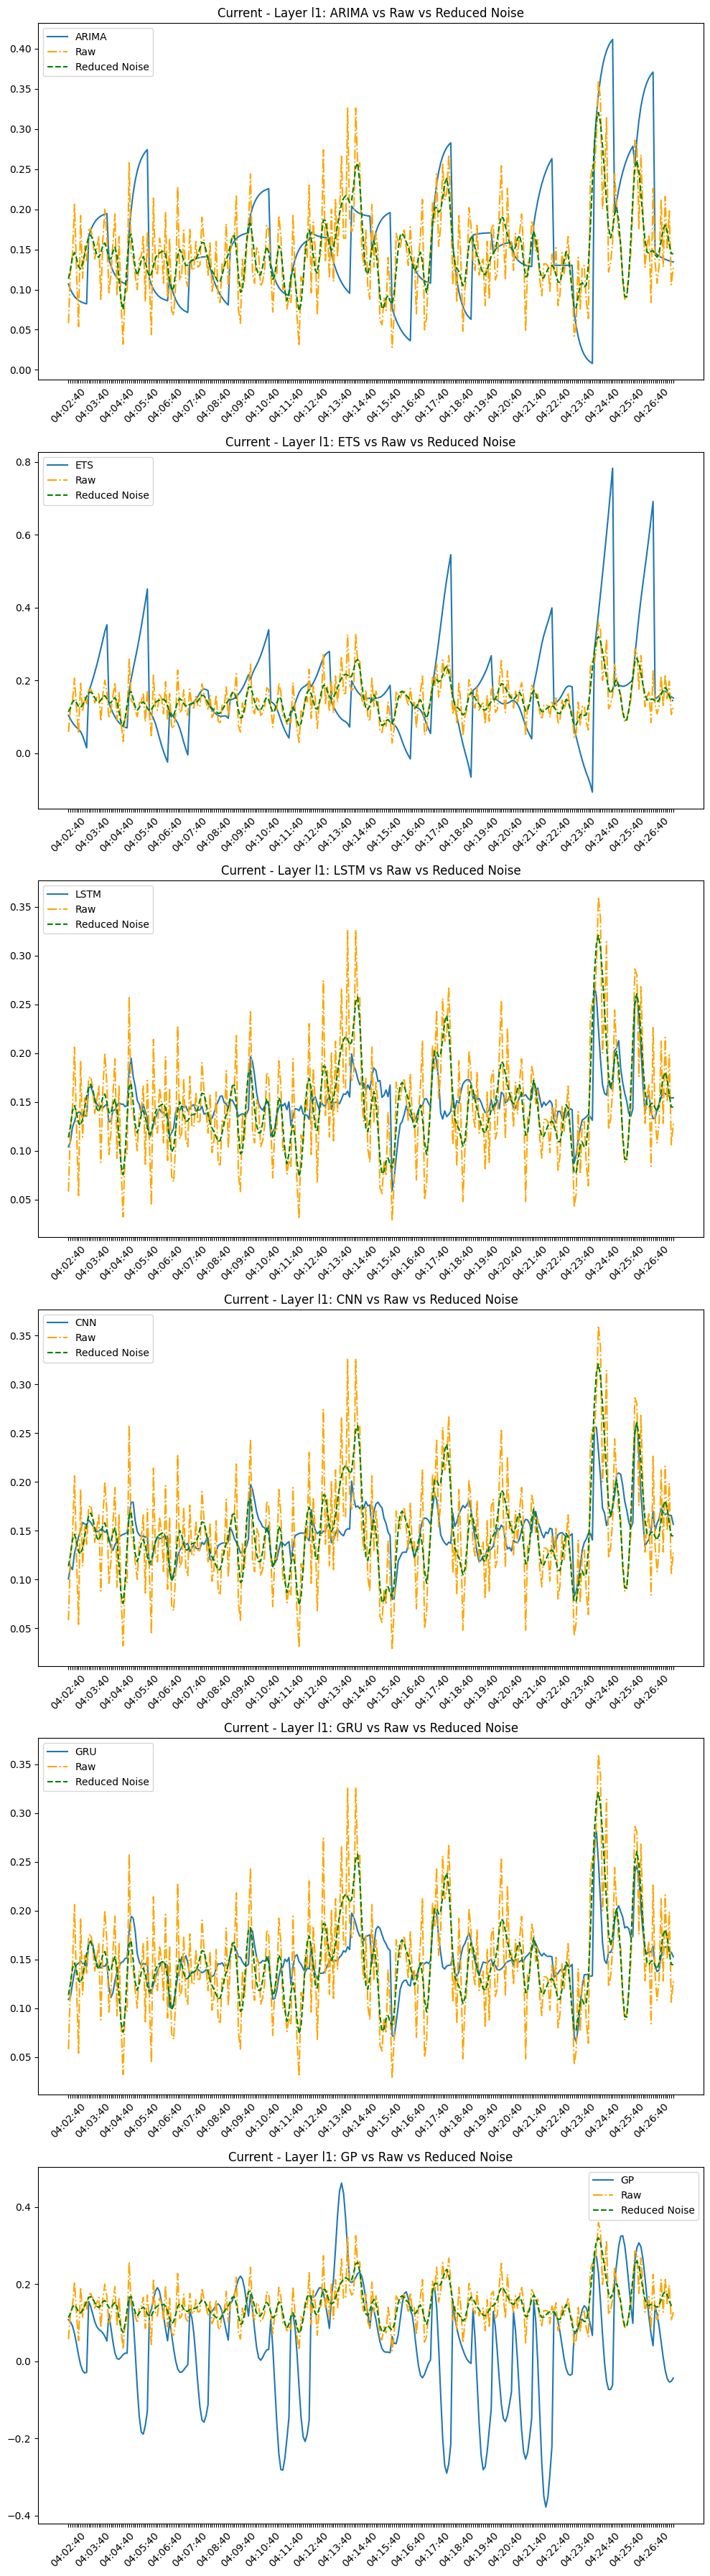

------------------


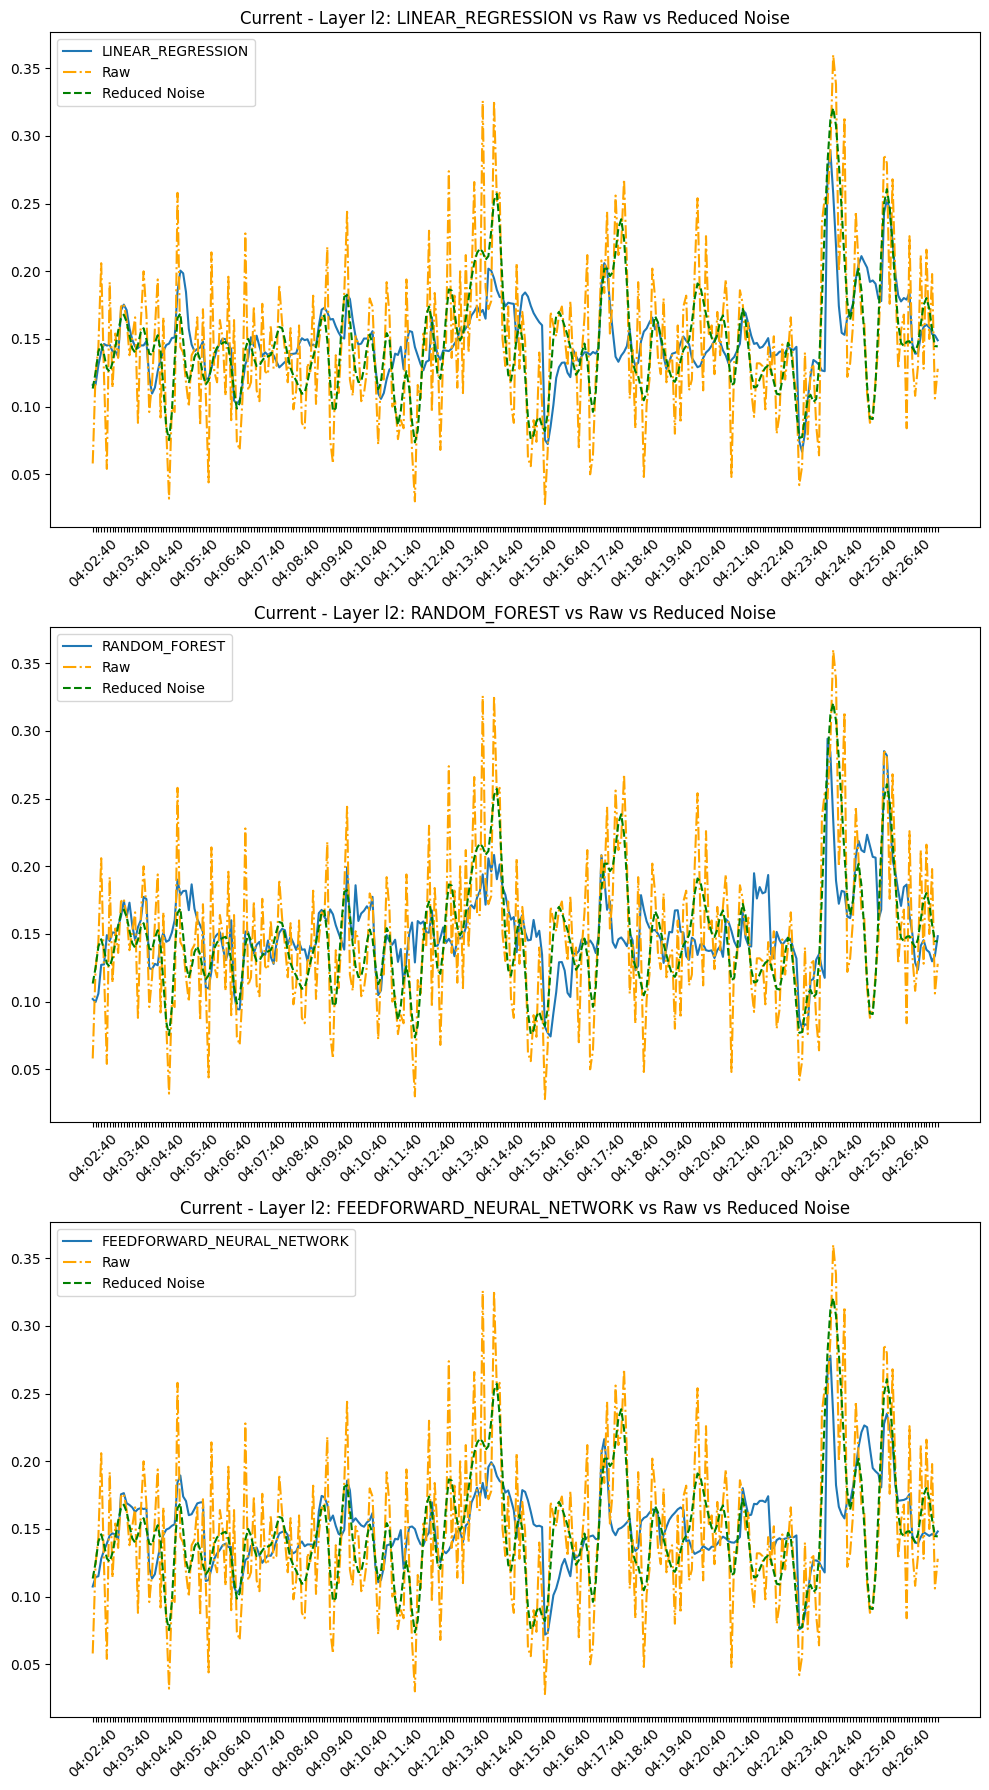

------------------


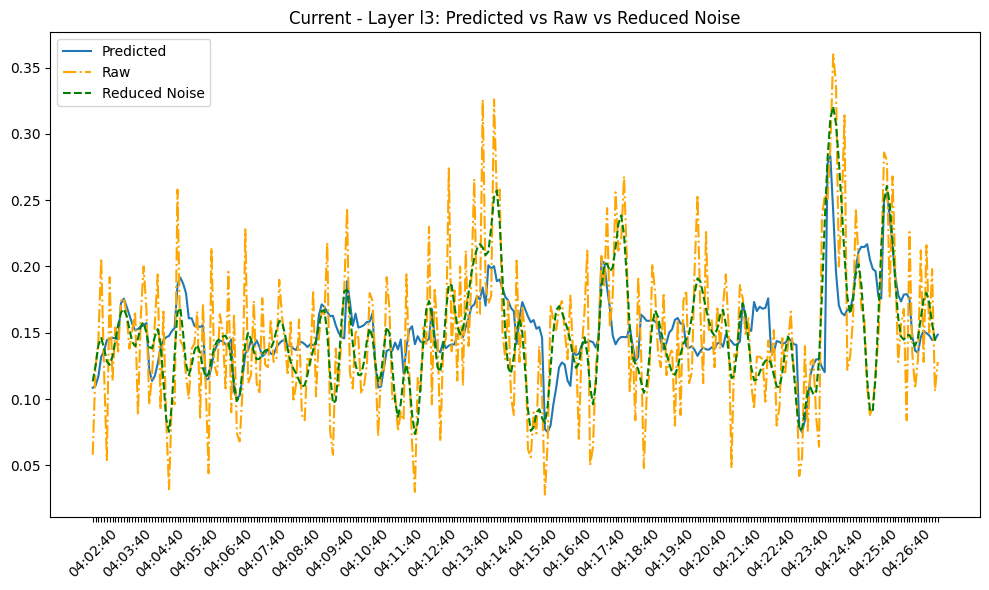

------------------


In [30]:
header = (str(ARCHIVED) if ARCHIVED is not None else "Current") + " - "
header = header if SHOW_HEADER else ""

for key, df in dfs.items():
    # Plot the data
    fig, axes = plt.subplots(
        nrows=len(df.columns) - len(IGNORED_COLS),
        figsize=(10, 6 * (len(df.columns) - len(IGNORED_COLS))),
    )

    # Ensure axes is always a list or array
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    ax_idx = 0  # Separate index for accessing axes

    for column in df.columns:
        if column not in IGNORED_COLS:
            actual_label = "Reduced Noise" if IS_FILTERED else "Raw"
            actual_color = "green" if IS_FILTERED else "orange"
            axes[ax_idx].plot(df["FormattedTime"], df[column], label=column)
            if IS_FILTERED:
                axes[ax_idx].plot(
                    df["FormattedTime"],
                    df["Raw"],
                    label="Raw",
                    linestyle="-.",
                    color="orange",
                )  # Added this line to plot the Raw values
            axes[ax_idx].plot(
                df["FormattedTime"],
                df["Actual"],
                label=actual_label,
                linestyle="--",
                color=actual_color,
            )

            # Sparse Tick Labels logic
            n = 12  # Display every n-th label
            for index, label in enumerate(axes[ax_idx].xaxis.get_ticklabels()):
                if index % n != 0:
                    label.set_visible(False)

            # Rotate the visible x-axis labels
            axes[ax_idx].tick_params(axis="x", rotation=45)

            axes[ax_idx].legend()
            # axes[ax_idx].grid(True) # Uncomment this line to show grid lines
            title = f"{header}Layer {key}: {column} vs Raw"
            if IS_FILTERED:
                title += " vs Reduced Noise"
            axes[ax_idx].set_title(title)
            ax_idx += 1  # Increment ax_idx

    plt.tight_layout()
    plt.show()
    print("------------------")